In [2]:
# Third-party
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
pl.style.use('apw-notebook')
%matplotlib inline

from scipy.spatial import Delaunay

In [3]:
sgr = np.genfromtxt("/Users/adrian/projects/streams/data/simulation/LM10/SgrTriax_DYN.dat", 
                    delimiter=" ", dtype=None, names=True)

In [4]:
sgr_c = coord.SkyCoord(ra=sgr['ra']*u.degree, 
                       dec=sgr['dec']*u.degree,
                       distance=sgr['dist']*u.kpc)

In [5]:
hsc_gama = pd.read_csv("/Users/adrian/Downloads/gama15RaDec.txt", sep=" ", names=['ra', 'dec'], skiprows=1)
hsc_xmm = pd.read_csv("/Users/adrian/Downloads/xmmRaDec.txt", sep=" ", names=['ra', 'dec'], skiprows=1)

hsc_fields = {'gama': hsc_gama, 'xmm': hsc_xmm}

In [6]:
hsc_c = {name: coord.SkyCoord(ra=np.asarray(f['ra'])*u.deg, dec=np.asarray(f['dec'])*u.deg)
         for name,f in hsc_fields.items()}

Note: this is wrong because the tesselation is done on angular coordinates...

In [67]:
hsc_hulls = {name: Delaunay(np.vstack((c.ra.degree,c.dec.degree)).T) for name,c in hsc_c.items()}

In [68]:
sgr_pts = np.vstack((sgr_c.ra.degree, sgr_c.dec.degree)).T

sgr_in_hsc_idx = {}
for name,hull in hsc_hulls.items():
    sgr_in_hsc_idx[name] = hull.find_simplex(sgr_pts) >= 0

---

## Plot all Sgr model stars colored by distance

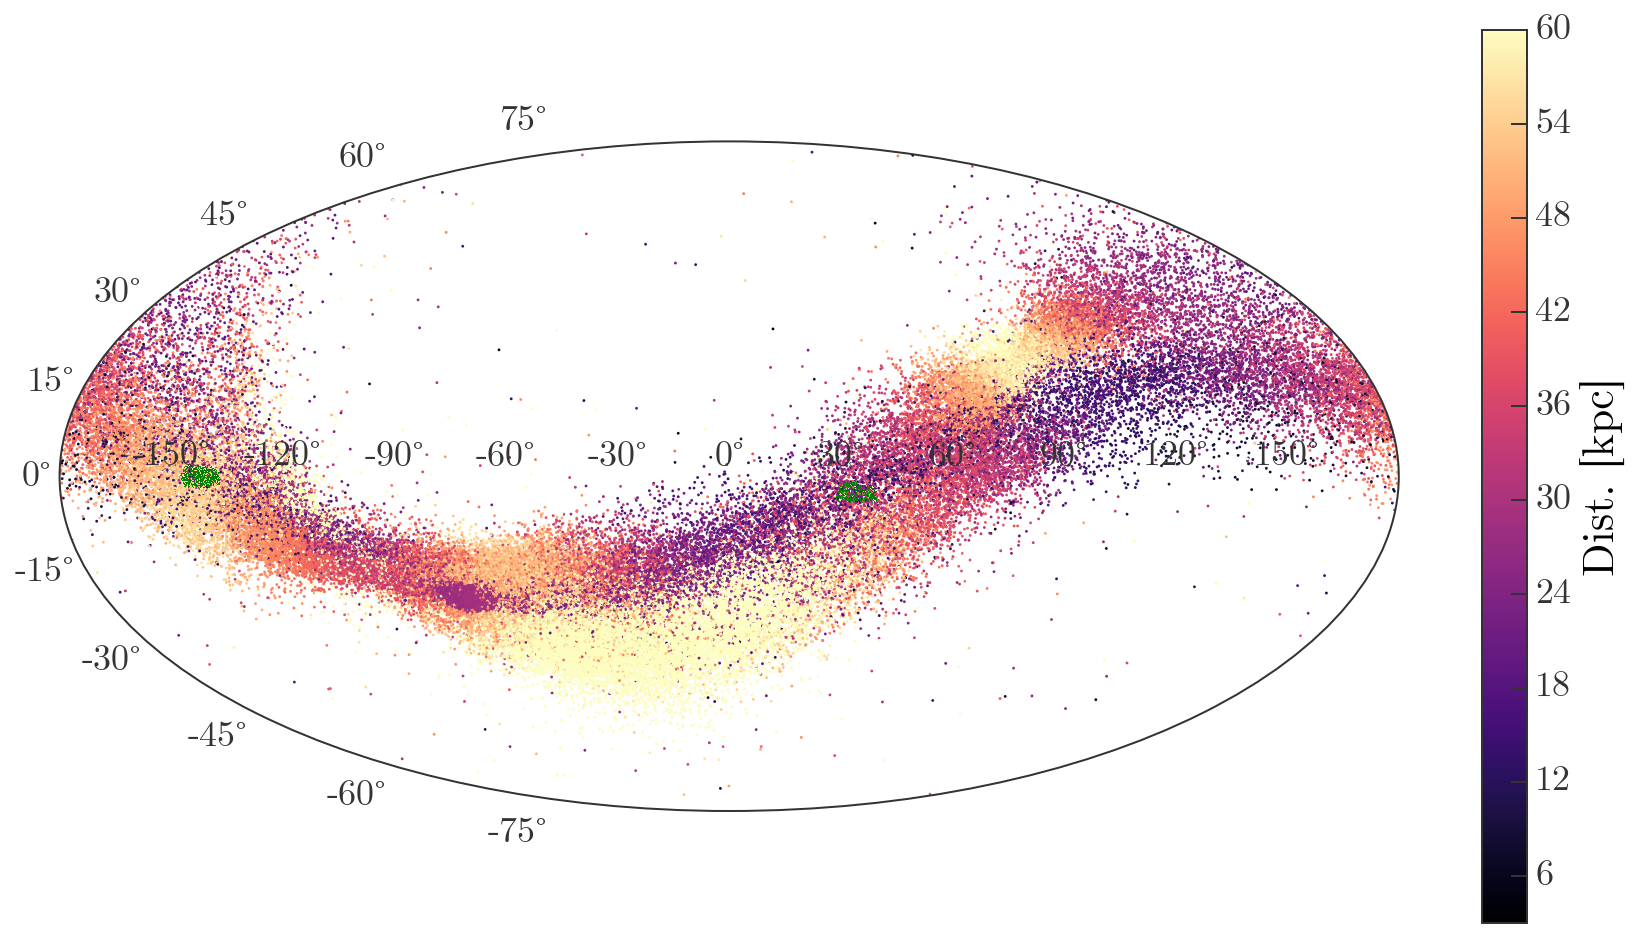

In [58]:
fig,ax = pl.subplots(1,1,figsize=(15,8),subplot_kw=dict(projection='aitoff'))

cb = ax.scatter(sgr_c.ra.wrap_at(180*u.degree).radian, sgr_c.dec.radian, 
               c=sgr_c.distance.kpc, cmap='magma', vmin=3, vmax=60, s=2)

for c in hsc_c.values():
    ax.plot(c.ra.wrap_at(180*u.degree).radian[::1000], c.dec.radian[::1000], 
            linestyle='none', marker=',', color='g')

cbar = fig.colorbar(cb)
cbar.set_label('Dist. [kpc]')

## Plot only Sgr stars in convex hull of HSC fields

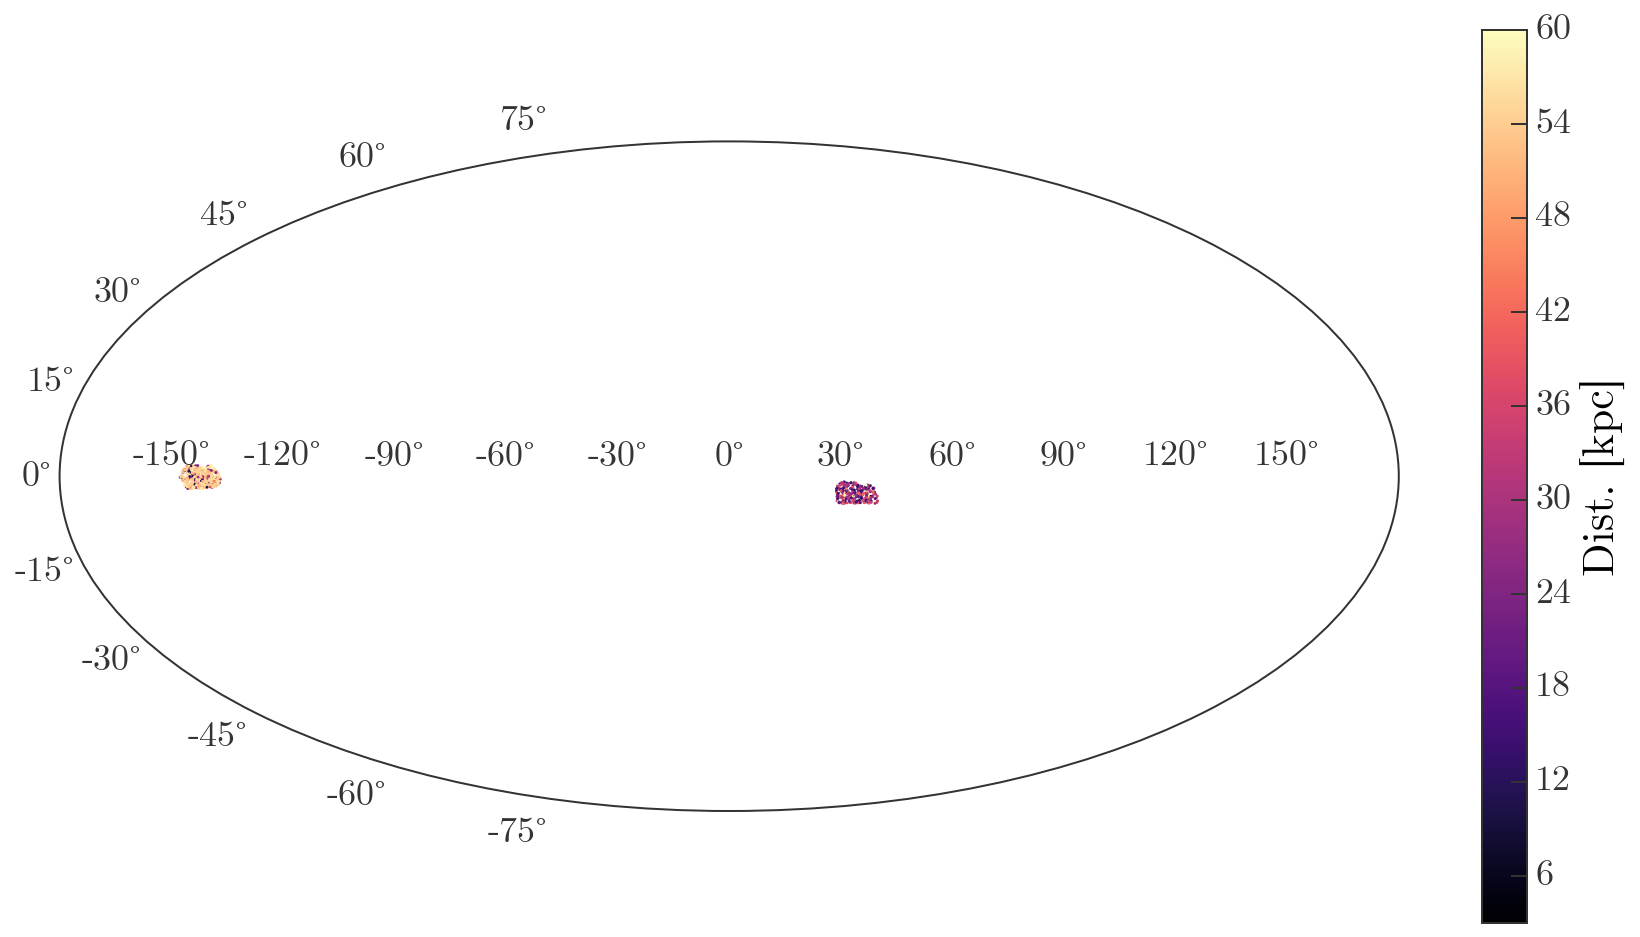

In [62]:
fig,ax = pl.subplots(1,1,figsize=(15,8),subplot_kw=dict(projection='aitoff'))

for name,idx in sgr_in_hsc_idx.items():
    cb = ax.scatter(sgr_c[idx].ra.wrap_at(180*u.degree).radian, sgr_c[idx].dec.radian, 
                    c=sgr_c[idx].distance.kpc, cmap='magma', vmin=3, vmax=60, s=2)
    
cbar = fig.colorbar(cb)
cbar.set_label('Dist. [kpc]')

## Distance / distance modulus histograms for the two fields

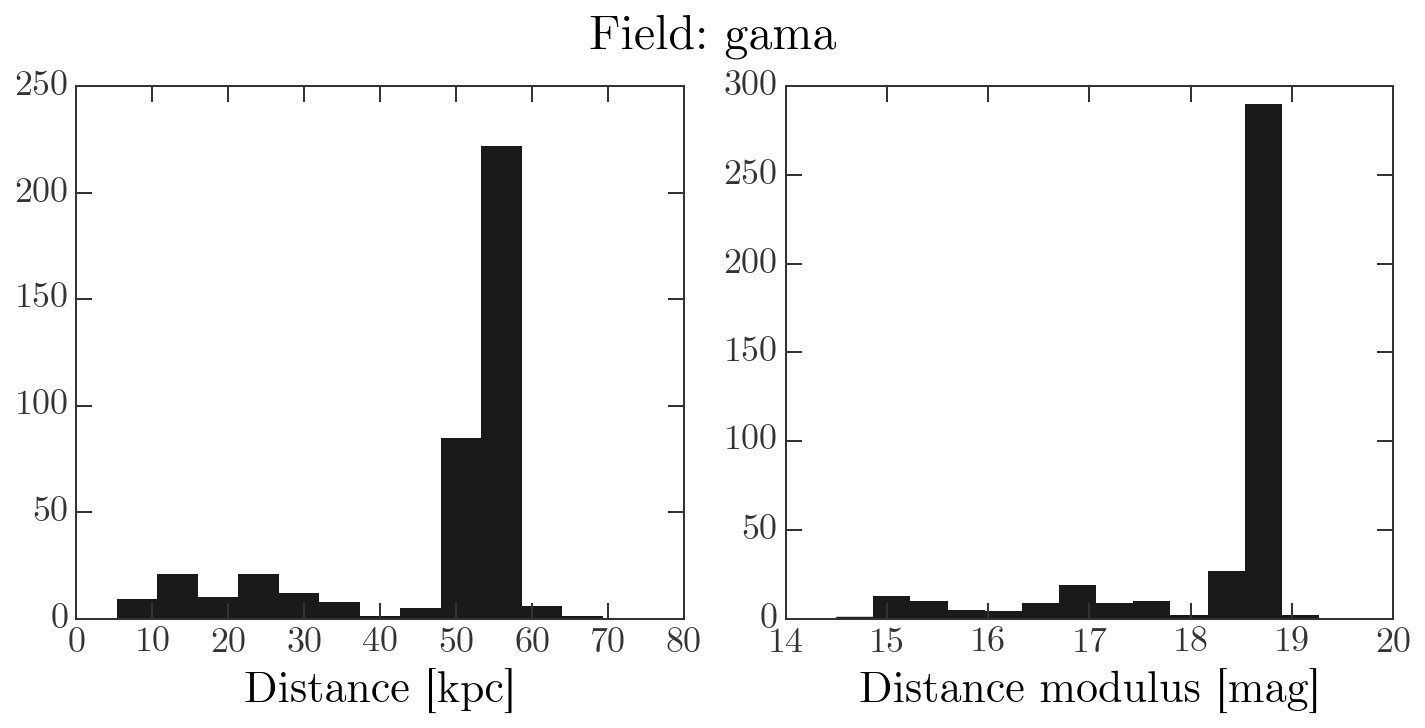

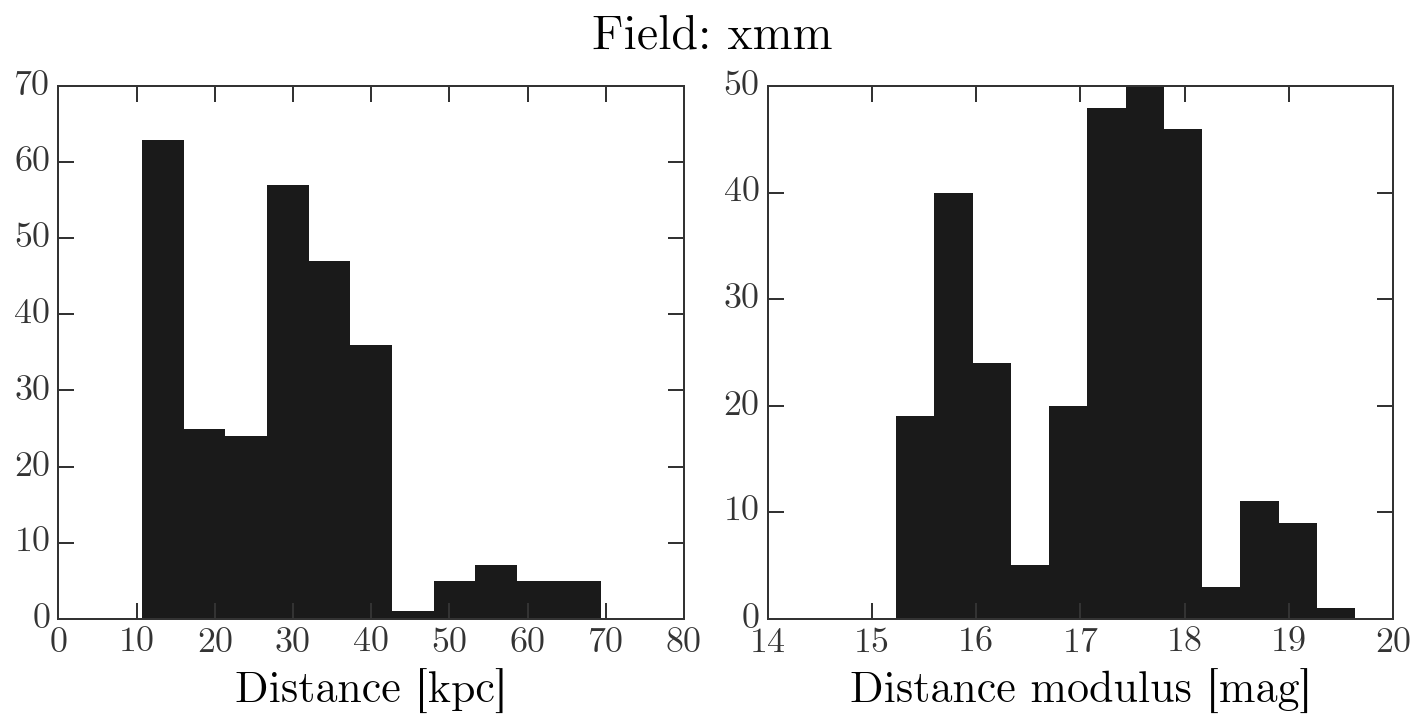

In [75]:
dist_bins = np.linspace(0.,80.,16) # kpc
distmod_bins = np.linspace(14.5,20.,16) # kpc

for name,idx in sgr_in_hsc_idx.items():
    fig,axes = pl.subplots(1,2,figsize=(10,5))
    axes[0].hist(sgr_c.distance.kpc[idx], bins=dist_bins)
    axes[1].hist(sgr_c.distance.distmod[idx], bins=distmod_bins)
    
    axes[0].set_xlabel("Distance [kpc]")
    axes[1].set_xlabel("Distance modulus [mag]")
    
    fig.suptitle("Field: {}".format(name), fontsize=24, y=1.0)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

---

In [1]:
from gala.coordinates import Sagittarius

In [7]:
sgr.dtype.names

('Lambda',
 'Beta',
 'ra',
 'dec',
 'l',
 'b',
 'xgc',
 'ygc',
 'zgc',
 'xsun',
 'ysun',
 'zsun',
 'x4',
 'y4',
 'z4',
 'u',
 'v',
 'w',
 'dist',
 'vgsr',
 'mul',
 'mub',
 'mua',
 'mud',
 'Pcol',
 'Lmflag')

(-100, 100)

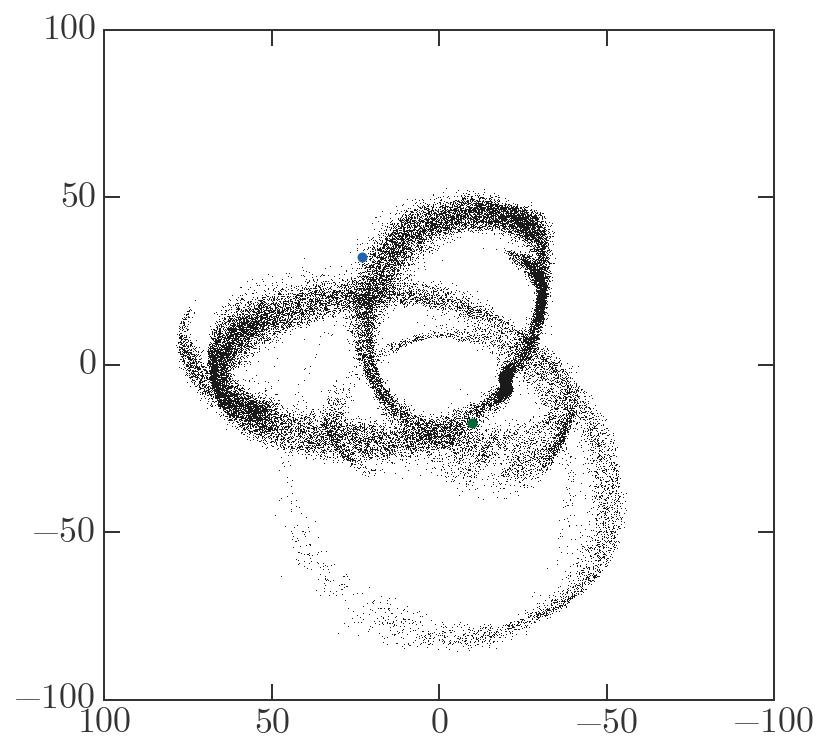

In [22]:
fig,ax = pl.subplots(1,1,figsize=(6,6))

ax.plot(sgr['xgc'][np.abs(sgr['Pcol'])<6], sgr['zgc'][np.abs(sgr['Pcol'])<6], 
        marker=',', ls='none')

_tmp = coord.SkyCoord(ra=np.median(hsc_c['gama'].ra), dec=np.median(hsc_c['gama'].dec), distance=40*u.kpc)
ax.plot(_tmp.galactic.cartesian.xyz[0], _tmp.galactic.cartesian.xyz[2], ls='none', marker='o')

_tmp = coord.SkyCoord(ra=np.median(hsc_c['xmm'].ra), dec=np.median(hsc_c['xmm'].dec), distance=20*u.kpc)
ax.plot(_tmp.galactic.cartesian.xyz[0], _tmp.galactic.cartesian.xyz[2], ls='none', marker='o')

ax.set_xlim(100,-100)
ax.set_ylim(-100,100)

(-100, 100)

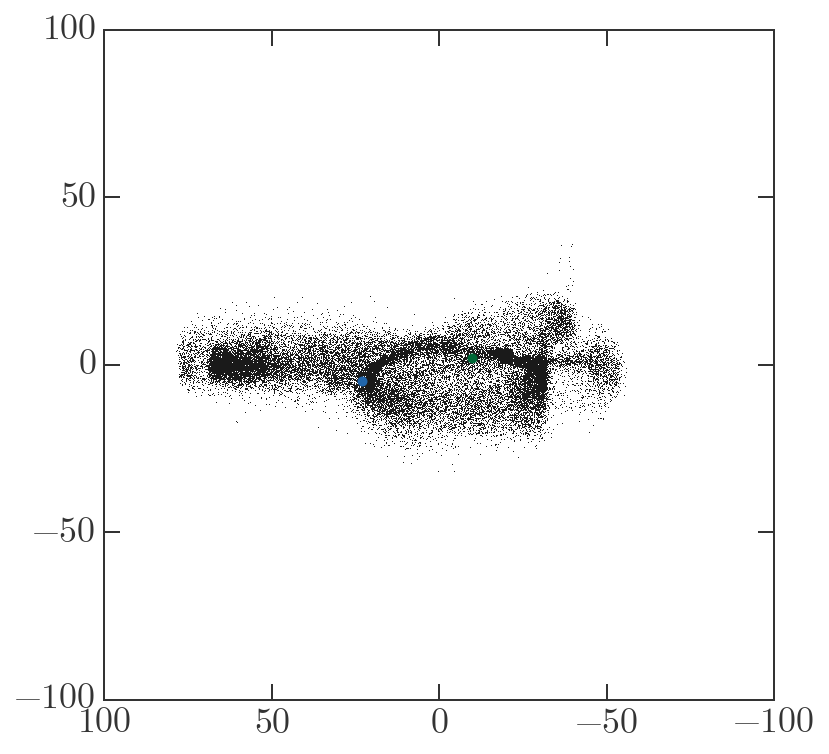

In [23]:
fig,ax = pl.subplots(1,1,figsize=(6,6))

ax.plot(sgr['xgc'][np.abs(sgr['Pcol'])<6], sgr['ygc'][np.abs(sgr['Pcol'])<6], 
        marker=',', ls='none')

_tmp = coord.SkyCoord(ra=np.median(hsc_c['gama'].ra), dec=np.median(hsc_c['gama'].dec), distance=40*u.kpc)
ax.plot(_tmp.galactic.cartesian.xyz[0], _tmp.galactic.cartesian.xyz[1], ls='none', marker='o')

_tmp = coord.SkyCoord(ra=np.median(hsc_c['xmm'].ra), dec=np.median(hsc_c['xmm'].dec), distance=20*u.kpc)
ax.plot(_tmp.galactic.cartesian.xyz[0], _tmp.galactic.cartesian.xyz[1], ls='none', marker='o')

ax.set_xlim(100,-100)
ax.set_ylim(-100,100)

(-20, 20)

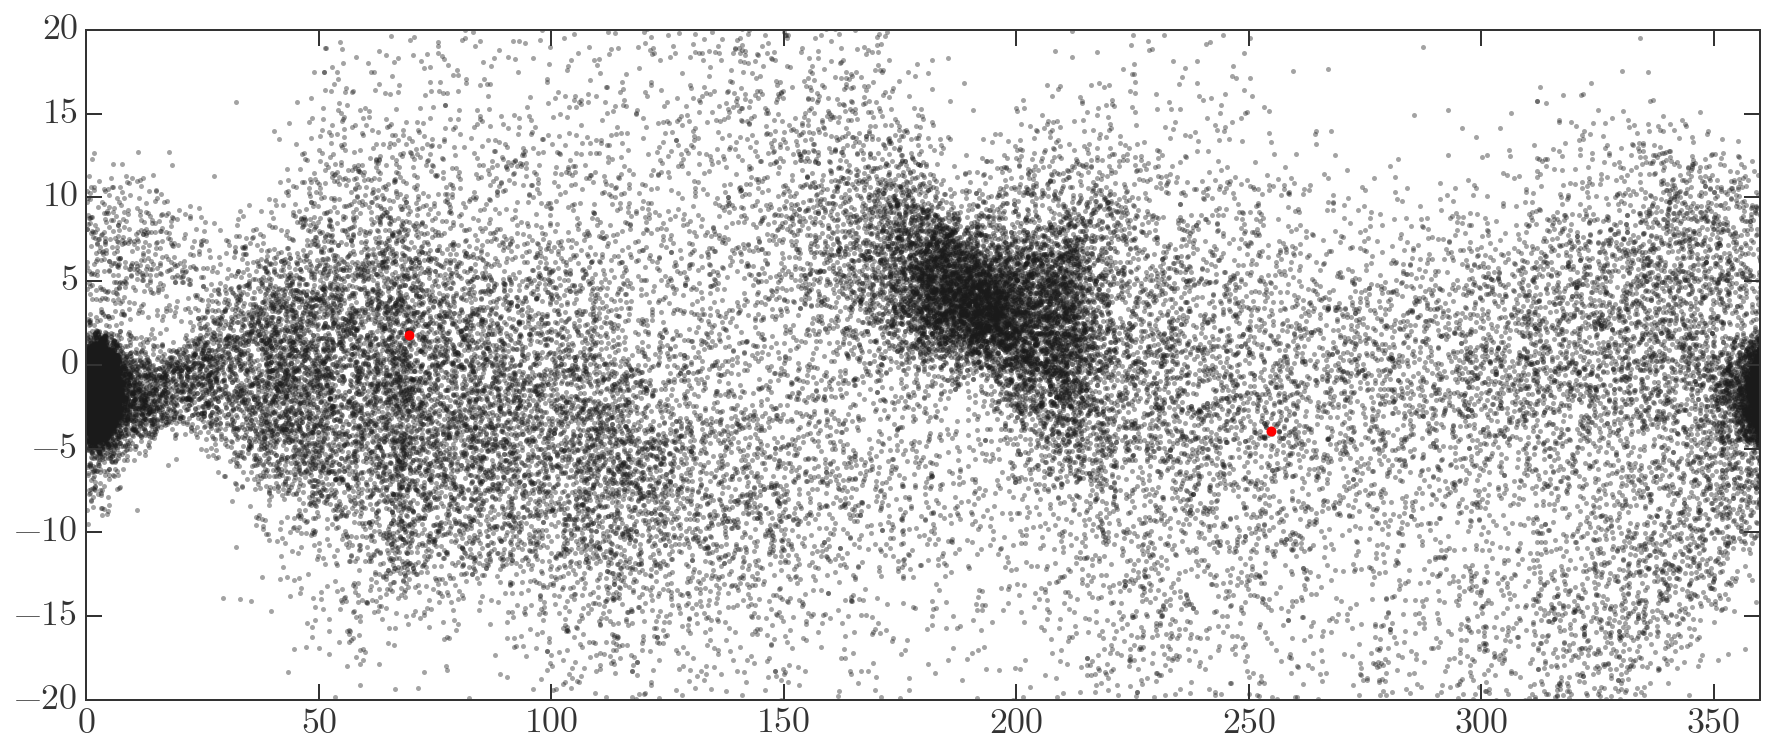

In [33]:
fig,ax = pl.subplots(1,1,figsize=(15,6))

ax.plot(360-sgr['Lambda'][np.abs(sgr['Pcol'])<6], -sgr['Beta'][np.abs(sgr['Pcol'])<6], 
        marker='.', ls='none', alpha=0.4)

_tmp = coord.SkyCoord(ra=np.median(hsc_c['gama'].ra), dec=np.median(hsc_c['gama'].dec), distance=40*u.kpc)
ax.plot(360-_tmp.transform_to(Sagittarius).Lambda.degree, 
        -_tmp.transform_to(Sagittarius).Beta.degree, ls='none', marker='o', color='r')

_tmp = coord.SkyCoord(ra=np.median(hsc_c['xmm'].ra), dec=np.median(hsc_c['xmm'].dec), distance=20*u.kpc)
ax.plot(360-_tmp.transform_to(Sagittarius).Lambda.degree, 
        -_tmp.transform_to(Sagittarius).Beta.degree, ls='none', marker='o', color='r')

ax.set_xlim(0,360)
ax.set_ylim(-20,20)

(0, 360)

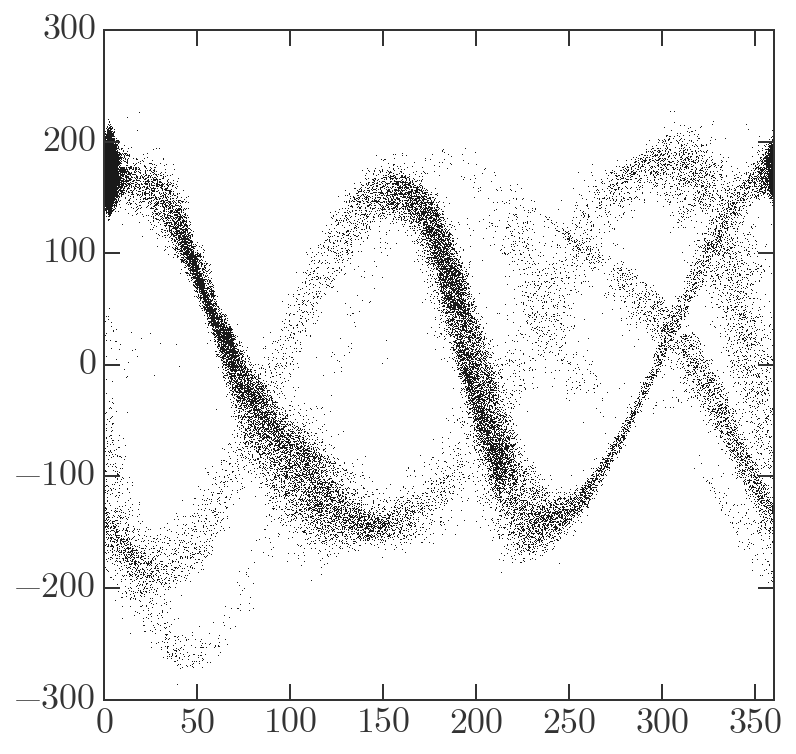

In [30]:
fig,ax = pl.subplots(1,1,figsize=(6,6))

ax.plot(360-sgr['Lambda'][np.abs(sgr['Pcol'])<6], sgr['vgsr'][np.abs(sgr['Pcol'])<6], 
        marker=',', ls='none')

ax.set_xlim(0,360)